#### Benchmark result

This notebook is an experiment of real-world data set: **EMPS**.

The Electro-Mechanical Positioning System (EPMS) is a standard configuration of a drive system for prismatic joint of robots or machine tools. 
The main source of nonlinearity is the nonlinear friction effects (e.g. static and dynamic friction). 

$Input$: 1D, $v(t)$, motor force; 

$Output$:1D, $qm$, motor position; 

$State$: 2D, $x=[q(t), \dot{q(t)}]^T$,position and velocity. 

The original data set has a length of 24842 and a sampling time of $\Delta t =1ms$, to mimic a case of irregularly sampling, I randomly maintained 10% of the raw data and formulated it to a new dataset. 

(Training and validate on resampled irregular dataset) Samples 0-2000 are used for training and samples 2000-2400 are used for validation.  Additionaly, using the whole another data set (set2) for testing so to compare the results with the previous benchmark results.


In [1]:

import torch
from normalization import Input_output_data     


import pandas as pd
df = pd.read_csv('/Users/bloodytaken/graduate_project/data/EMPS/DATA_EMPS_PULSES_irregular.csv')

# Extract data
u = torch.tensor(df['u'].values, dtype=torch.float32).view(-1, 1)  
y = torch.tensor(df['y'].values, dtype=torch.float32).view(-1, 1)  
delta_t = torch.tensor(df['dt'].values, dtype=torch.float32).view(-1, 1)  

# For test below
state_cols = [c for c in df.columns if c.startswith('TrueState_')]
x = torch.tensor(df[state_cols].values, dtype=torch.float32)   # (N , nx)

print(u.shape, y.shape, delta_t.shape, x.shape)   #  sanity-check
data = Input_output_data(u, y, delta_t, x=x, name='irregular_sampling')

# Split dataset
train, val = data[:2000], data[2000:]

# Another set for testing
df_test   = pd.read_csv('/Users/bloodytaken/graduate_project/data/EMPS/DATA_EMPS_test.csv' )

u_t = torch.tensor(df_test['u' ].values, dtype=torch.float32).view(-1,1)
y_t = torch.tensor(df_test['y' ].values, dtype=torch.float32).view(-1,1)
dt_t= torch.tensor(df_test['dt'].values,dtype=torch.float32).view(-1,1)
state_cols_t = [c for c in df_test.columns if c.startswith('TrueState_')]
x_t = torch.tensor(df_test[state_cols_t].values, dtype=torch.float32)

test = Input_output_data(u_t, y_t, dt_t, x=x_t, name='test_set')

print(f'{train = }')
print(f'{val   = }')
print(f'{test  = }')   



torch.Size([2484, 1]) torch.Size([2484, 1]) torch.Size([2484, 1]) torch.Size([2484, 0])
train = Input_output_data "irregular_sampling" u.shape=torch.Size([2000, 1]), y.shape=torch.Size([2000, 1]), sampling_time varying, length=2000
val   = Input_output_data "irregular_sampling" u.shape=torch.Size([484, 1]), y.shape=torch.Size([484, 1]), sampling_time varying, length=484
test  = Input_output_data "test_set" u.shape=torch.Size([24841, 1]), y.shape=torch.Size([24841, 1]), sampling_time varying, length=24841


Number of samples to train on = 1946


  0%|          | 0/100000 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.93163!! nan samps/sec
it     100 NRMS loss 0.40556 NRMS val 0.24315!! 1297.84 samps/sec
it     200 NRMS loss 0.08383 NRMS val 0.53687   1307.04 samps/sec
it     300 NRMS loss 0.07517 NRMS val 0.36695   1302.37 samps/sec
it     400 NRMS loss 0.06987 NRMS val 0.42398   1286.53 samps/sec
it     500 NRMS loss 0.06715 NRMS val 0.49341   1272.63 samps/sec
it     600 NRMS loss 0.06353 NRMS val 0.47936   1277.06 samps/sec
it     700 NRMS loss 0.06219 NRMS val 0.43597   1276.43 samps/sec
it     800 NRMS loss 0.06025 NRMS val 0.36515   1277.84 samps/sec
it     900 NRMS loss 0.05853 NRMS val 0.30914   1277.81 samps/sec
it   1,000 NRMS loss 0.05907 NRMS val 0.46470   1278.37 samps/sec
it   1,100 NRMS loss 0.05550 NRMS val 0.31983   1277.41 samps/sec
it   1,200 NRMS loss 0.05475 NRMS val 0.38874   1282.16 samps/sec
it   1,300 NRMS loss 0.05395 NRMS val 0.38306   1284.42 samps/sec
it   1,400 NRMS loss 0.05204 NRMS val 0.56982   1287.19 samps/sec
it   1,500 NRMS lo

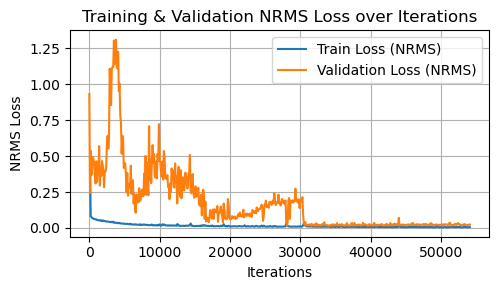

In [2]:
from normalization import get_nu_ny_and_auto_norm
from models import SUBNET_ISTS
from networks import rk4_integrator

nu, ny, norm = get_nu_ny_and_auto_norm(train)
torch.manual_seed(1)
model = SUBNET_ISTS(nu, ny, norm, nx=2, na=5, nb=5, integrator=rk4_integrator)

from fitting import fit
train_dict = fit(model, train=train, val=val, n_its=100000, T=50, batch_size=64, val_freq=100)


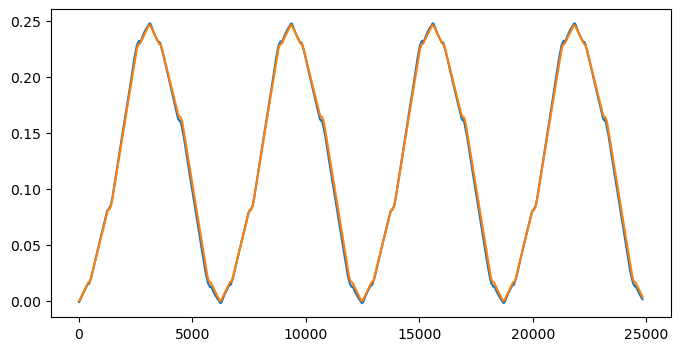

NRMS = 3.92%
RMSE = 0.0032 m


In [3]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
test_sim = model.simulate(test)

y_true = test.y[model.na:]
y_pred = test_sim.y[model.na:]

if hasattr(y_true, 'detach'):
    y_true = y_true.detach().cpu().numpy()
if hasattr(y_pred, 'detach'):
    y_pred = y_pred.detach().cpu().numpy() # convert to numpy format

plt.plot(test_sim.y) #sim
plt.plot(test.y)
plt.show()
from nonlinear_benchmarks.error_metrics import NRMSE, RMSE

print(f'NRMS = {NRMSE(y_true, y_pred)[0]:.2%}')
print(f'RMSE = {RMSE(y_true, y_pred)[0]:.4f} m')

RMSE = 3.240 mm


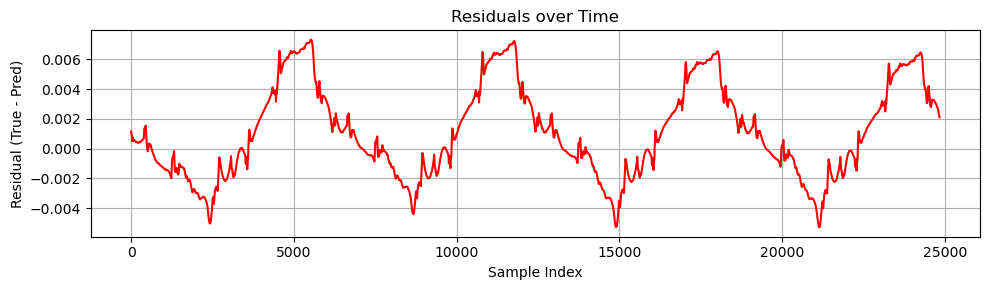

In [4]:
import numpy as np 
residuals = y_true - y_pred
rmse  = np.sqrt(np.mean(residuals**2)) # RMSE
print(f"RMSE = {rmse*1000:.3f} mm")    
plt.figure(figsize=(10, 3))
plt.plot(residuals, color='red')
plt.title('Residuals over Time')
plt.xlabel('Sample Index')
plt.ylabel('Residual (True - Pred)')
plt.grid(True)
plt.tight_layout()
plt.show()